# Who wrote this? A Study for Authorship Attribution

"I ought to be thy Adam, but I am rather the fallen angel."

"Nothing is so painful to the human mind as a great and sudden change."

"It is the nature of truth in general, as of some ores in particular, to be richest when most superficial."

"The oldest and strongest emotion of mankind is fear, and the oldest and strongest kind of fear is fear of the unknown."

![alt text](img/shelley.jpg) ![alt text](img/poe.png) ![alt text](img/lovecraft.jpg)

Edgar Allan Poe, Mary Shelley, Howard Phillips Lovecraft

# Definition of a Machine Learning Problem 
**Objective:**
Identify the writer of a sentence

**Data:**
For each writer a list of sentences from works of e.g. like Frankenstein, The Unparalleled Adventure of Hans Pfaall, The Call of Cthulhu

# Data Exploration
## Tools

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from os import path
from nltk.stem import WordNetLemmatizer
from functools import reduce, partial
from itertools import groupby
import nltk, operator, warnings, pprint
warnings.filterwarnings(action='ignore')

# Utilities
identity = lambda x: x
first = lambda x: x[0]
second = lambda x: x[1]

def compose(*functions):
    """Returns a function as composition of fuctions: f,g,..,h -> f°g°..°h"""
    return reduce(lambda f, g: lambda x: f(g(x)),
                            functions,
                            identity)

# Return container objects instead of iterators
mapl = lambda f,xs: list(map(f,xs))
reversedl = compose(list, reversed)
rangel = compose(list, range)
filterl = lambda f,xs: list(filter(f,xs))

## Tokenization and Provisions

In [2]:
d = pd.read_csv('data/train.csv')
#execute only once to download resources: nltk.download('stopwords') nltk.download('punkt') nltk.download('wordnet')
d['tokens'] = d.text.apply(nltk.word_tokenize)
d.head()

,id,text,author,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,"[This, process, ,, however, ,, afforded, me, n..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[It, never, once, occurred, to, me, that, the,..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[In, his, left, hand, was, a, gold, snuff, box..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[How, lovely, is, spring, As, we, looked, from..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[Finding, nothing, else, ,, not, even, gold, ,..."


In [3]:
# Further provisions of token preprocessing
# Remove heading apostrophes as their occurrence is highly unbalanced among writer's corpora (might be due to publishing reasons)
filter_heading_apostrophes = compose(list,
                                     partial(filter, lambda tokens: "'"!=tokens[0][0]))

transform_lower_case = compose(list,
                               partial(map, lambda token: token.lower()))

d.tokens = d.tokens.apply(compose(filter_heading_apostrophes,
                                  transform_lower_case))

## Vocabulary in the Corpus
Which words are used by whom at what frequency? Corpus as a whole and writers' corpora

In [4]:
tokenList = partial(reduce, operator.concat)
frequencies = lambda l: sorted([(k, len(list(v))) for k,v in groupby(sorted(l))],
                               key=second, reverse=True)

writers = ['EAP', 'HPL', 'MWS']
corpora = ['corpus'] + writers
allTokens, vocabulary, tokenFreq = {}, {}, {}
for c in corpora:
    if c=='corpus':
        allTokens[c] = tokenList(d.tokens)
    else:       
        allTokens[c] = tokenList(d[d.author==c].tokens)
    vocabulary[c] = set(allTokens[c])
    tokenFreq[c] = frequencies(allTokens[c])
    print('Number of tokens in', c, len(allTokens[c]))

Number of tokens in corpus 589810
Number of tokens in EAP 229700
Number of tokens in HPL 172378
Number of tokens in MWS 187732


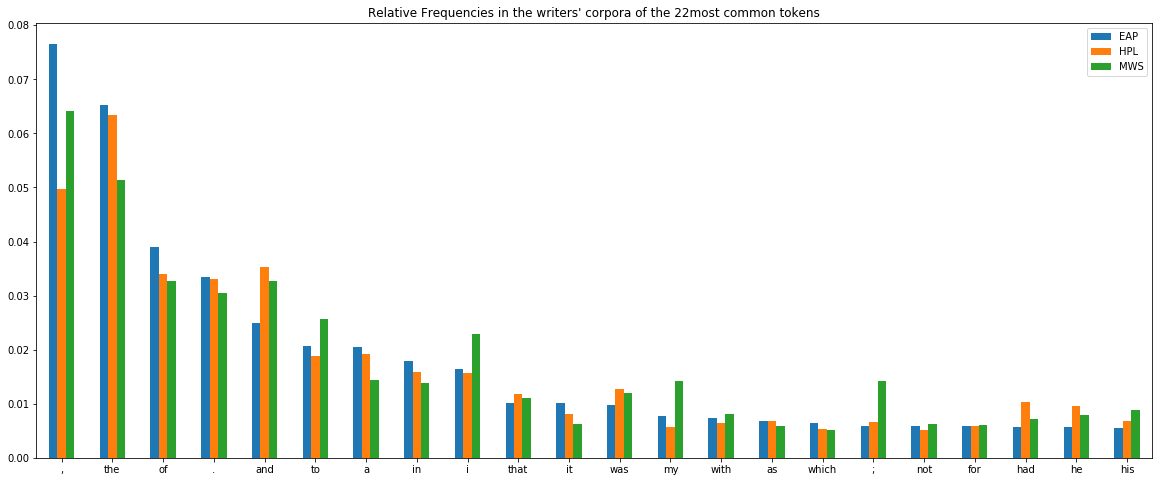

In [5]:
first_n_most_frequent_tokens = lambda n: mapl(first, tokenFreq['corpus'][:n])

def relative_token_frequency(tokens, corpus):
    dict_freq = dict(tokenFreq[corpus])
    return {k: dict_freq[k]/len(allTokens[corpus]) for k in tokens}

n_w = 22
most_freq_tokens = pd.DataFrame.from_dict(
    dict(zip(writers,
             map(partial(relative_token_frequency, first_n_most_frequent_tokens(n_w)),
                 writers)))).sort_values(by=['EAP'], ascending=False)



most_freq_tokens.plot.bar(rot=0, figsize=(20, 8), title='Relative Frequencies in the writers\' corpora of the ' + str(n_w) + 'most common tokens');

**Takeaway:**  There might be a chance to classify by most common words. These might represent or indicate authorical styles like narrative perspective

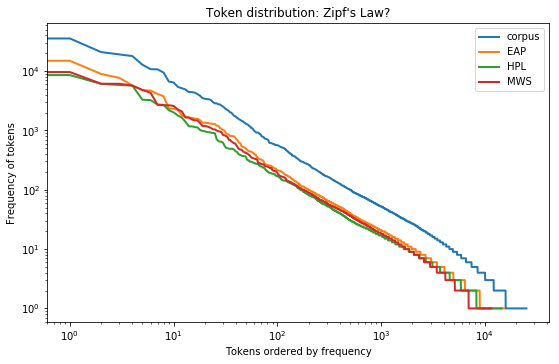

In [6]:
plt.figure(figsize=(9,5.5));
for c in corpora:
    plt.loglog(rangel(len(tokenFreq[c])),
               mapl(second, tokenFreq[c]),
               linewidth=2);
plt.title('Token distribution: Zipf\'s Law?'); plt.xlabel('Tokens ordered by frequency');
plt.ylabel('Frequency of tokens'); plt.legend(corpora);

In [7]:
singletons = filterl(compose(lambda x: x==1, second), tokenFreq['corpus'])
print('Number of tokens occuring only once', len(singletons), 'e.g. among them:\n', mapl(first, singletons[:80]))

Number of tokens occuring only once 9307 e.g. among them:
 ['a.d', 'a.d.', 'a.m', 'aaem', 'ab', 'abaft', 'abased', 'abasement', 'abashed', 'abashment', 'abated', 'abating', 'abbeys', 'abbé', 'abdicated', 'abdications', 'abdomen', 'aberrancy', 'aberration', 'abide', 'abijah', 'abjure', 'ablaze', 'ably', 'abolished', 'aboriginal', 'abortion', 'abounded', 'aboundingly', 'absconded', 'absense', 'absolved', 'absorb', 'absorbingly', 'absorption', 'abstain', 'abstained', 'abstaining', 'abstemious', 'abstractions', 'abstractly', 'abstruseness', 'absurdness', 'absurdum', 'abuse', 'abused', 'abxut', 'abysms', 'accaount', 'accede', 'acceptation', 'accepting', 'acclaimed', 'acclamation', 'acclamations', 'acclivity', 'accompaniment', 'accomplices', 'accordant', 'accorto', 'accredited', 'accrue', 'accrued', 'accruing', 'acct', 'accumulate', 'accumulation', 'accumulative', 'accursedly', 'accusations', 'accusers', 'accuses', 'accusing', 'acetous', 'acheron', 'acherontic', 'achieving', 'acidulous', 'ac

# Ansatz: Model on Most Common Words
Naive Bayes classifier on the frequency of common words in a sentence

In [8]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

## Vectorization

In [9]:
filter_by_set = lambda coll: compose(list,
                                     partial(filter, lambda x: x in coll))
# frequencies -> Sparse Matrix:
frequencies_in_tokens = lambda tokens, vocabulary: dv.fit_transform(
                                                    map(compose(dict,
                                                            frequencies,
                                                            filter_by_set(vocabulary)),
                                                        tokens))

## Model Construction

In [10]:
number_common_words = 200
Y = d.author
X = frequencies_in_tokens(d.tokens,
                          first_n_most_frequent_tokens(number_common_words))
model = MultinomialNB().fit(X,Y)
Y_pred = model.predict(X)

## Model Evaluation

In [11]:
precision = lambda x, y: sum(x == y) / len(x)

def classifier_assessment(model_class, X, Y) -> None:
    return {'in-sample-precision':
            round(precision(Y, model_class.fit(X,Y).predict(X)), 3),
            'out-of-sample-precision':
            round(np.mean(cross_val_score(model_class, X, Y, cv=8)), 3)}

print('Classification report, in-sample\n', classification_report(Y, Y_pred))
print('precision, out-of-sample\n', classifier_assessment(model, X, Y)['out-of-sample-precision'])
print('\nConfusion Matrix, in-sample')
pd.DataFrame(confusion_matrix(Y, Y_pred, labels=writers), columns=writers, index=writers)

Classification report, in-sample
               precision    recall  f1-score   support

         EAP       0.67      0.68      0.67      7900
         HPL       0.59      0.66      0.62      5635
         MWS       0.67      0.59      0.63      6044

   micro avg       0.65      0.65      0.65     19579
   macro avg       0.64      0.64      0.64     19579
weighted avg       0.65      0.65      0.65     19579

precision, out-of-sample
 0.639

Confusion Matrix, in-sample


,EAP,HPL,MWS
EAP,5350,1414,1136
HPL,1307,3701,627
MWS,1325,1135,3584


## Model Variations
### Sensitivity towards Number of Common Words

In [12]:
commonwords_sizes = [10, 50, 100, 200, 400, 600, 1000, 1500, 2000, 5000, 10000]
precs_in, precs_out = [], []
for n in commonwords_sizes:
    X_n = frequencies_in_tokens(d.tokens, first_n_most_frequent_tokens(n))
    res = classifier_assessment(MultinomialNB(), X_n, Y)
    precs_in.append(res['in-sample-precision'])
    precs_out.append(res['out-of-sample-precision'])

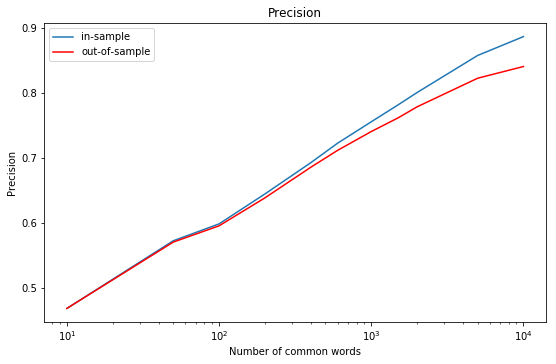

In [13]:
plt.figure(figsize=(9,5.5));
plt.semilogx(commonwords_sizes, precs_in);
plt.semilogx(commonwords_sizes, precs_out, 'r');
plt.xlabel('Number of common words'); plt.ylabel('Precision'); plt.title('Precision');
plt.legend(['in-sample', 'out-of-sample']);

Take no more than 200 words as from then on content bearings words appear, e.g. character names like Raymond.

### Sensitivity towards Model Class
Other and more complex models lead to no better results.

In [14]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier

X = frequencies_in_tokens(d.tokens,
                          first_n_most_frequent_tokens(number_common_words))

model_classes = {'NaiveBayes': MultinomialNB(),
                 'SVM-one-vs-rest': LinearSVC(),
                 'RandomForest': RandomForestClassifier(),
                 'GradientBoosting': GradientBoostingClassifier(n_estimators= 100, max_depth = 5),
                 'Nearest-Centroid': NearestCentroid(),
                 '10-Nearest-Neibors': KNeighborsClassifier(n_neighbors=10),
                 '20-Nearest-Neibors': KNeighborsClassifier(n_neighbors=10)}

pd.DataFrame.from_dict(dict(mapl(lambda m: [m, classifier_assessment(model_classes[m], X, Y)],
                                 model_classes.keys())))

,NaiveBayes,SVM-one-vs-rest,RandomForest,GradientBoosting,Nearest-Centroid,10-Nearest-Neibors,20-Nearest-Neibors
in-sample-precision,0.645,0.669,0.986,0.726,0.478,0.609,0.609
out-of-sample-precision,0.639,0.658,0.590,0.663,0.476,0.519,0.519


# Multinomial Bayes Classifier and its Interpretation
## Probabilistic Model
In an multinomial model the random variable of feature occurrence counts $X = (X_1, \ldots, X_n)$ has the *distribution conditional on class* $Y$

$$ P_k \left\{ X_1 = x_1,\ldots, X_n =x_n | Y \right\} = \frac{m!}{x_1!\ldots x_n!} \prod_{k=1\dots n} p_{k|y}^{x_k}$$

**Interpretation:** Using this model implies that a writer $y$ builds a sentence of length $m$ by picking $m$-times from the set of common words where each common word $k$ appears with probability $p_{k|y}$.

## Estimation of Model Parameters
Sklearn *estimates* these probabilities (recalling source code MultinomialNB._count) by the relative frequencies in the corpus for a class $y$

\begin{align}
 \hat p_{k|y} & = \frac{c_{k,y}}{c_y} \\
      c_{k,y} & = \sum_{\omega| Y(\omega) = y} X_k(\omega) + \alpha \\
      c_y     & = \sum_k c_{k|y}
\end{align}
The parameter $\alpha$ regularizes.

**Interpretation:**
* The writer picks randomly a word from all the words he has ever written 
* puts it back and repeats $m$-times

![alt text](img/um.jpg)

Note: This is a portfolio approach in which the occurrences among single observations are irrelevant, e.g. observing two times a frequency of 2 yielding the same as 0 and 4 each one time.

## Model's Decision Function
The calibrated Bayes model attributes observation $x$ to the probability being of class $y$ 
$$P\{ Y=y | X=x \} = \frac{P\{Y=y\} P\{X=x|Y=y\}} {P\{X=x\}} $$

With evidence the same for all classes a Bayes classifier would attribute the class with the highest probability

$$\text{classifier:} ~~ x \longrightarrow \text{argmax}_{y} P\{Y=y\} P\{X=x | Y=y\}$$

The latter returns the same when transforming the probabilities in the following way

\begin{align}
 & P\{ Y=y \} P\{ X=x | Y=y \} \\
 & = P\{ Y=y \}  \frac{m!}{x_1!\ldots x_n!} \prod_{k=1\dots n} p_{k|y}^{x_k} \\
 & \approx P\{ Y=y \} \prod_{k=1\dots n} p_{k|y}^{x_k} \\
 & \approx \log P\{ Y=y \} + \sum_{k=1\ldots n} x_k \log p_{k|y}
\end{align}

## Model Insight: Features with high predictive power
High or low conditional probability of a word given an author $\log p_{k|y}$ impacts the decision functions the most (Ignoring the priors for a moment, which are anyhow relatively even)

In [15]:
common_words = first_n_most_frequent_tokens(n)
log_prob = dict(zip(model.classes_,
             map(lambda xs: list(sorted(zip(common_words, xs),
                                 key=lambda x: x[1], reverse=True)),
                (map(lambda x: np.round(x,2), model.feature_log_prob_)))))

def pretty_print_dict(diction):
    for k in diction.keys(): print('\t\t', k,'\t', diction[k])

for w in writers:
    print(w, '\n\tHighest_Log_Probilities'); pretty_print_dict(dict(log_prob[w][:5]))
    print('\tLowest Log Probabilities'); pretty_print_dict(dict(log_prob[w][-5:]))

EAP 
	Highest_Log_Probilities
		 , 	 -2.13
		 thing 	 -2.29
		 where 	 -2.81
		 the 	 -2.96
		 he 	 -3.25
	Lowest Log Probabilities
		 most 	 -7.96
		 house 	 -8.12
		 they 	 -8.91
		 light 	 -9.6
		 once 	 -11.91
HPL 
	Highest_Log_Probilities
		 thing 	 -2.25
		 , 	 -2.49
		 he 	 -2.83
		 where 	 -2.88
		 the 	 -2.9
	Lowest Log Probabilities
		 three 	 -7.99
		 come 	 -8.78
		 will 	 -8.91
		 most 	 -9.47
		 once 	 -10.45
MWS 
	Highest_Log_Probilities
		 , 	 -2.31
		 thing 	 -2.53
		 he 	 -2.99
		 where 	 -2.99
		 the 	 -3.06
	Lowest Log Probabilities
		 love 	 -7.88
		 death 	 -7.92
		 know 	 -8.41
		 few 	 -8.41
		 day 	 -11.71


#  Questions so far
 * Why does the usual tf-idf approach not work for author attribution?
 * Why is in-sample and out-of-sample precision so close?
 * .. but not for random forests?

##  Enhance Features with Statistics
Add to the above frequencies of common words the following statistics
 * sentence length
 
The stastistics alone has predictive power. Find a way for incorporation into above model approaches. It adds also nicely to the interpretation of naive Bayes classifier in the sense that a poet first pick from the distribution of length of the sentences he has ever written, and then picks the words -frankly, all choices independent.

In [36]:
sentence_lengths = np.array(list(map(len, d.tokens))).reshape(-1, 1)
classifier_assessment(MultinomialNB(), sentence_lengths, Y)
from scipy.sparse import coo_matrix, hstack
X_sentenceLength = hstack([X, sentence_lengths])

for m in ['SVM-one-vs-rest', 'NaiveBayes']:
    print(m, classifier_assessment(model_classes[m], X_sentenceLength, Y))

SVM-one-vs-rest {'in-sample-precision': 0.64, 'out-of-sample-precision': 0.639}
NaiveBayes {'in-sample-precision': 0.649, 'out-of-sample-precision': 0.643}


*Conclusion:* Added sentences length adds a bit of accuracy for, at least for the Bayes Model, whereas it impairs the classification power of the SVM. 
The latter might be healed by normalizing the sentence lengths to a similar order of scale as the frequencies(whicht in turn might spoil the sparsity of the approach). 

# Outlook
### Encoding
Experiment with other text encodings on other level. Like on

**Character Level**
 * occurrence of character sequences
 * punctuation
   * eg. frequency of commas, semicolons, periods, quotation-marks

**Lexical Level**
 * stemming
 * lemmatization
 * enlarge common tokens while filter names and places

**Syntactical Level**
 * part of speech
   word classes as lexical items: noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, numeral, article, determiner
 * part of sentence
   consituents as lexical items: subject, predicate, direct/indirect object, modifier, abvervial,
 * sentence 

**Semantic Level**
 * .. better not
  
### Structure
Pick up more structure than just order-neglecting counts 
 
**Respect Word Order** 
 * Encoding sentences as sequences
 * n-grams, eg character 3-grams |No_| |o_o| |_on| |one|
 * Markov Models? LSTMs

# Second Approach: Learning Sequences with Deep Nets
Following the example 
https://www.tensorflow.org/tutorials/keras/basic_text_classification
We respect the order of sentences and feed the sequences to neural networks: